## 카드 소비 데이터

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import dask.dataframe as dd
import vaex

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst

In [3]:
data = '../data/five_city_data/merged_gyeonggi_day.csv'

In [4]:
# Dask로 5개 주요시 데이터 읽기
card_df = dd.read_csv(data,encoding='utf-8')


In [5]:
card_df.head()

,ta_ymd,cty_rgn_no,admi_cty_no,card_tpbuz_cd,card_tpbuz_nm_1,card_tpbuz_nm_2,hour,sex,age,day,amt,cnt
0,20230101,41210,41210510,D05,소매/유통,선물/완구,3,M,5,7,57576,2
1,20230101,41210,41210510,D11,소매/유통,종합소매점,3,F,7,7,8523,2
2,20230101,41210,41210510,D11,소매/유통,종합소매점,7,F,7,7,8023,2
3,20230101,41210,41210510,F02,생활서비스,미용서비스,3,M,4,7,28532,2
4,20230101,41210,41210510,F02,생활서비스,미용서비스,4,F,7,7,74074,2


In [6]:
card_df.isna().sum()

Dask Series Structure:
npartitions=1
admi_cty_no    int64
ta_ymd           ...
dtype: int64
Dask Name: dataframe-sum-agg, 4 graph layers

In [7]:
card_df.count().compute(scheduler='processes', num_workers=2)

ta_ymd             115322615
cty_rgn_no         115322615
admi_cty_no        115322615
card_tpbuz_cd      115322615
card_tpbuz_nm_1    115322615
card_tpbuz_nm_2    115322615
hour               115322615
sex                115322615
age                115322615
day                115322615
amt                115322615
cnt                115322615
dtype: int64

In [8]:
#card_df.sort_values(by=['ta_ymd', 'card_tpbuz_nm_1','card_tpbuz_nm_2'])

In [9]:
#card_df.groupby(['ta_ymd', 'card_tpbuz_nm_1','card_tpbuz_nm_2', 'sex'])

In [10]:
card_df['cty_rgn_no'].nunique().compute()

11

### 코드를 위한 데이터 분리 및 결합

In [11]:
code_mapping = card_df[["card_tpbuz_cd",	"card_tpbuz_nm_1",	"card_tpbuz_nm_2"	]].drop_duplicates()

In [12]:
#해당 일, 특정행정동의 업종별, 연령별, 나이별 매출액 평균과 매출 건수
# grouped_df = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd", "sex", "age"]).agg({"amt": "mean", "cnt": "sum"}).reset_index()

In [13]:
# grouped_df.sort_values(by=["ta_ymd", "card_tpbuz_cd","admi_cty_no"])

In [14]:
# 해당 일의 해당동의 업종 별 매출 평균
time_df = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "mean"}).reset_index()
# time_df의 해당 일의 해당 업종의 평균
time_df2 = time_df.groupby(['ta_ymd',	'card_tpbuz_cd']).agg({"amt": "mean"}).reset_index()

In [15]:
time_df2.head()

,ta_ymd,card_tpbuz_cd,amt
0,20230101,D05,107508.458419
1,20230101,D11,872746.393065
2,20230101,F02,202663.628225
3,20230101,Q01,191551.970288
4,20230101,Q15,383799.991835


In [16]:
#grouped_df['ta_ymd'] = pd.to_datetime(grouped_df['ta_ymd'], format='%Y%m%d')
# 다음날 매출을 라벨로 추가
#grouped_df['next_day_sales'] = grouped_df.groupby(['admi_cty_no', 'card_tpbuz_cd', 'sex', 'age'])['amt'].shift(-1)
# 데이터 확인
# grouped_df[(grouped_df['ta_ymd'] == '2023-01-01') & 
#                              (grouped_df['admi_cty_no'] == 41210510) & 
#                              (grouped_df['card_tpbuz_cd'] == 'F02')]

In [17]:
# 40104
len(time_df2)

40104

### 날짜 타입 변환

In [18]:
time_df2 = time_df2.compute()

In [19]:
# time_df2['ta_ymd'] = time_df2['ta_ymd'].astype(str)
time_df2['ta_ymd'] = pd.to_datetime(time_df2['ta_ymd'], format='%Y%m%d')

## 모델 학습 -> AutoML 활용

In [20]:
# autogluon 사용
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [71]:
# train, test 분리
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(time_df2, test_size=0.2, random_state=42)
time_df2 = time_df2.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])

In [80]:
# 각 그룹별로 train/test 데이터 나누기
# train_list = []
# test_list = []

# for card, group in time_df2.groupby('card_tpbuz_cd'):
#     train, test = train_test_split(group, test_size=0.2, shuffle=False)  # 시간 순서를 유지하여 분할
#     train_list.append(train)
#     test_list.append(test)

# # train/test 데이터 합치기
# train_df = pd.concat(train_list)
# test_df = pd.concat(test_list)


# train/test 데이터 나누기 (2024년 4월 데이터를 테스트 데이터로)
train_df = time_df2[time_df2['ta_ymd'] < '2024-04-01']
test_df = time_df2[time_df2['ta_ymd'] >= '2024-04-01']

train_df = train_df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
test_df = test_df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])

In [81]:
test_df

,ta_ymd,card_tpbuz_cd,amt
37662,2024-04-01,D01,6.402779e+05
37738,2024-04-02,D01,3.676375e+05
37811,2024-04-03,D01,3.379875e+05
37886,2024-04-04,D01,3.796846e+05
37966,2024-04-05,D01,4.526875e+05
...,...,...,...
39559,2024-04-26,Y05,1.619942e+06
40039,2024-04-27,Y05,5.138403e+05
40048,2024-04-28,Y05,1.035920e+06
40050,2024-04-29,Y05,2.982654e+05


In [82]:
train_data = TimeSeriesDataFrame.from_data_frame(train_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

In [83]:
train_data.reset_index()

,item_id,timestamp,amt
0,D01,2023-01-01,1.731074e+06
1,D01,2023-01-02,5.965027e+05
2,D01,2023-01-03,3.948372e+05
3,D01,2023-01-04,4.022331e+05
4,D01,2023-01-05,3.370238e+05
...,...,...,...
37622,Y05,2024-03-27,6.021892e+05
37623,Y05,2024-03-28,1.107779e+05
37624,Y05,2024-03-29,2.122845e+05
37625,Y05,2024-03-30,7.107628e+04


In [84]:
# train_data = TimeSeriesDataFrame.from_data_frame(time_df2, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

In [85]:
# train_data = train_data.sort_values(by=['item_id', 'timestamp'])

In [86]:
predictor = TimeSeriesPredictor(label="amt", prediction_length=28, eval_metric="RMSE", freq="D")

In [87]:
predictor.fit(train_data, random_seed = 42,time_limit=120)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to 'AutogluonModels\ag-20240711_110628'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          0
Memory Avail:       19.75 GB / 31.69 GB (62.3%)
Disk Space Avail:   587.36 GB / 930.86 GB (63.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 28,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'amt',
 'time_limit': 120,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'D'.
Provided train_data has 37846 rows (NaN fraction=0.6%), 

In [88]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean            0.1            0.2  \
item_id timestamp                                                 
D01     2024-04-01  574022.623114  407750.120193  449882.491368   
        2024-04-02  496614.235901  334107.716060  385312.203198   
        2024-04-03  523273.593669  343436.326320  395735.573812   
        2024-04-04  477588.928910  293388.901673  353734.469293   
        2024-04-05  527661.859741  319270.486351  392342.295703   

                              0.3            0.4            0.5  \
item_id timestamp                                                 
D01     2024-04-01  500390.523928  526352.042139  562280.215415   
        2024-04-02  416309.569229  450901.438672  478690.072120   
        2024-04-03  443237.570433  477151.196613  514601.847516   
        2024-04-04  399343.202014  437499.936379  476550.707331   
        2024-04-05  433255.708568  472902.953913  518480.973782   

                              0.6            0.7            0.8            0.9  
item_id timestamp                                                               
D01     2024-04-01  594970.131643  619859.041000  674804.908931  820859.601630  
        2024-04-02  510379.909781  547917.457042  611714.581921  740534.061293  
        2024-04-03  548085.328348  592509.252400  643434.498708  737071.065951  
        2024-04-04  524636.469207  560694.094590  621880.655825  688504.062164  
        2024-04-05  555551.471936  614194.200814  667121.434447  807730.421518

data with frequency 'None' has been resampled to frequency 'D'.


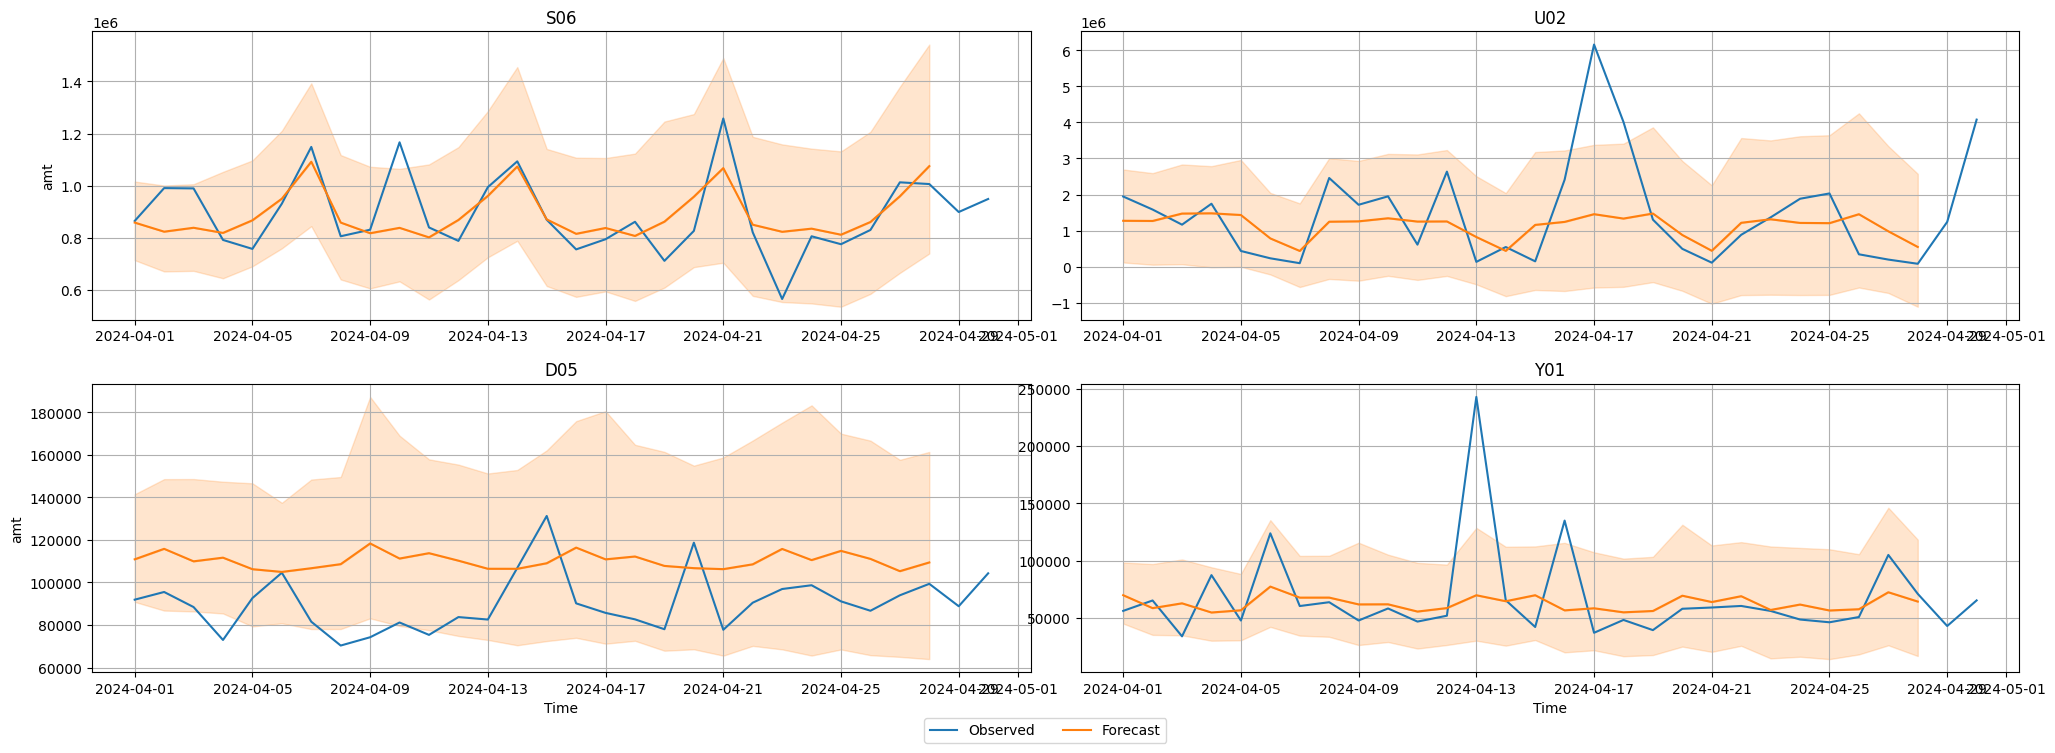

In [89]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_data_frame(test_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [90]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency 'D'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,SeasonalNaive,-438952.336676,-772738.835615,0.138392,2.267347,0.036417,1
1,RecursiveTabular,-438952.336676,-525906.487300,1.626964,1.143614,8.467157,2
2,NPTS,-447786.062568,-495208.661869,0.173110,1.368201,0.033314,4
3,WeightedEnsemble,-447945.041602,-487277.239662,2.722831,4.155125,0.935255,8
4,DirectTabular,-457670.457348,-516277.772088,1.922618,0.149449,1.075073,3
5,DeepAR,-458360.308878,-518790.870536,2.082089,1.928731,20.357272,6
6,TemporalFusionTransformer,-461803.322413,-523076.268953,0.283261,0.163647,20.286531,5
7,PatchTST,-470207.487816,-501990.283905,0.201488,0.206481,20.104577,7


In [91]:
# item_id가 'D05'인 데이터만 필터링
# train_df = train_data.reset_index()
# d05_df = train_df[train_df['item_id'] == 'F11']
